# LSTM with MNIST (or Fashion MNIST)

* This code is available to tensorflow version 2.0
* Implemented by [`tf.keras.layers`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers) [`tf.losses`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/losses)

## 1. Import Modules

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 2. Hyperparameters

In [2]:
# Training Flags (hyperparameter configuration)
model_name = 'lstm_mnist'
train_dir = os.path.join('train', model_name, 'exp')
dataset_name = 'mnist'
assert dataset_name in ['mnist', 'fashion_mnist']

max_epochs = 50
batch_size = 4
learning_rate = 1e-4

width, height = 14, 14
TEST = False


## 3. Load the MNIST dataset

(60000, 14, 14)


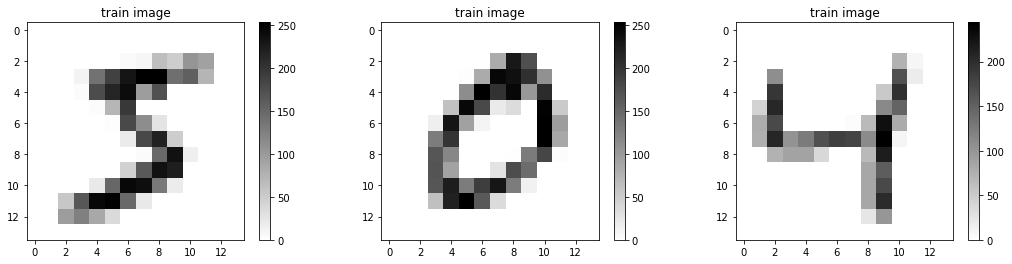

In [3]:
# Load training and eval data from tf.keras
if dataset_name == 'mnist':
  (train_images, train_labels), _ = \
      tf.keras.datasets.mnist.load_data()
else:
## Load the MNIST dataset  (train_images, train_labels), _ = \
      tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')

train_images = tf.image.resize(train_images, size=[width, height])
train_images = tf.cast(train_images[:, :, :, 0], tf.int64)

print(train_images.shape)

plt.figure(figsize=[18, 4])
for i in range(3):
    
    plt.subplot(1, 3, i+1)
    plt.title('train image')
    plt.imshow(train_images[i], cmap='binary')
    plt.colorbar()

plt.show()
    

## 4. Create a dataset object

In [4]:
#tf.random.set_seed(117)
# for train
N = len(train_images)
        
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(buffer_size=N)
train_dataset = train_dataset.batch(batch_size=batch_size)
print(train_dataset)


<BatchDataset shapes: (None, 14, 14), types: tf.int64>


## 5. LSTM Functions

In [5]:
class Model(tf.keras.Model):
    def __init__(self, vocab_size=256, embed_dim=512, h_dim=512):
        super(Model, self).__init__()
        
        self.global_step = tf.Variable(0, trainable=False)
        
        self.embedding = layers.Embedding(vocab_size, embed_dim)
        self.lstm_cell = layers.LSTMCell(units=h_dim)
        self.logit_layer = layers.Dense(vocab_size)
        
    def call(self, x):
        # x : [batch, length]
        
        # [batch, length, embed_dim]
        x = self.embedding(x)
        
        # LSTM states tuple
        init_states = self.lstm_cell.get_initial_state(batch_size=x.shape[0], dtype=tf.float32)
        states = init_states
        output_list = []
        for i in range(x.shape[1]):
            # output : [batch, h_dim]
            # states : (h : [batch, h_dim], c : [batch, h_dim])
            output, states = self.lstm_cell(inputs=x[:, i], states=states)
            output_list.append(output)
        
        outputs = tf.stack(output_list, axis=1)
        logits = self.logit_layer(outputs)
        
        return logits
        
    def inference(self, batch_size):
        x = tf.zeros([batch_size, 1], dtype=tf.int64)
        
        # [batch, 1, embed_dim]
        x = self.embedding(x)
        
        # LSTM states tuple
        init_states = self.lstm_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
        states = init_states
        samples = []
        
        for i in range(width*height):
            # output : [batch, h_dim]
            # states : (h : [batch, h_dim], c : [batch, h_dim])
            output, states = self.lstm_cell(inputs=x[:, -1], states=states)
            
            # [batch, vocab_size]
            logit = self.logit_layer(output)
            # [batch, 1]
            sample = tf.random.categorical(logit, num_samples=1)
            samples.append(sample)
            
            # [batch, ..., embed_dim]
            x = tf.concat([x, self.embedding(sample)], axis=1)
            
        # [batch, width*height]
        samples = tf.concat(samples, axis=1)
        
        return samples

## 6. Create a model object 

In [6]:
model = Model()
print(model)

### 2D-image to 1D-vector, 1D-vector to 2D-image

In [7]:
def image_to_vector(images):
    batch, height, width = images.shape
    vector = tf.reshape(images, [batch, height*width])
    return vector

def vector_to_image(vectors, height, width):
    batch, dim = vectors.shape
    images = tf.reshape(vectors, [batch, height, width])
    return images


### Create a unconditional image 

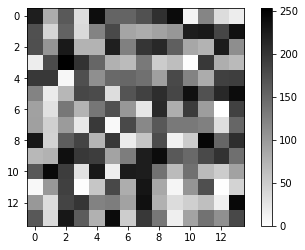

In [8]:
images = model.inference(batch_size=4)
pred = vector_to_image(images, width, height)
plt.imshow(pred[0], cmap='binary')
plt.colorbar()


## 7. Loss Function and Optimizer

In [9]:
cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate)

## 8. Define a single train step

In [10]:
@tf.function
def train_step(model, optimizer, images):
    
    with tf.GradientTape() as tape:
           
        images_shifted = tf.concat([tf.zeros([images.shape[0], 1], dtype=tf.int64), images[:, :-1]], axis=1)
        logit = model(images_shifted)
        loss = cce(images, logit)
        
    gradient = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))
    
    return logit, loss
        

## 9. Main Train Loop

Creating Images...


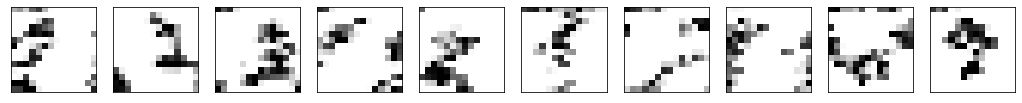

global step : 1100 cross-entropy loss : 1.4541236


KeyboardInterrupt: 

In [11]:

for epoch in range(max_epochs):
    for i, images in enumerate(train_dataset):
        images = image_to_vector(images)
        
        logit, loss = train_step(model, optimizer, images)
        model.global_step.assign_add(1)
        global_step = model.global_step.numpy()
        
        if global_step % 100 == 0:
            print('global step :', global_step, 'cross-entropy loss :', loss.numpy())
        
        if global_step % 1000 == 0:
            display.clear_output(wait=True)
            
            print('Creating Images...')
            images = model.inference(batch_size=10)
            pred = vector_to_image(images, width, height)
            
            plt.figure(figsize=[18, 3])
            for j in range(10):
                plt.subplot(1, 10, j+1)
                plt.imshow(pred[j], cmap='binary')
                plt.xticks([])
                plt.yticks([])
            plt.show()     
            